In [1]:
# Libraries Import
import pandas as pd
import requests as rq
import os
import warnings
import seaborn as sns
import numpy as np
from io import BytesIO
import openpyxl
import time
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import scipy.stats as ss
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#from pandas_profiling import ProfileReport
sns.set_style('white')
sns.set_context("paper", font_scale = 1)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Extract & Transform Processes
# Import the dataframe
#url = "https://github.com/fernandezramiroj/Work_Assignment/blob/main/Data.xlsx"    #importing from GitHub not working
#myfile = rq.get(url)
#with pd.ExcelFile(myfile.content, engine="openpyxl") as excel:
    #df = pd.read_excel(excel)
df = pd.read_excel(r'C:\Users\ramir\Downloads\Data.xlsx', sheet_name='Data')        #local import
# Index the df using the Employee ID and then removing it as a column
df.index = df['Employee ID']
# Remove spaces in headers
df.columns = df.columns.str.replace(' ', '')
# Remove unnecessary columns to reduce the analysis
df = df.drop(['EmployeeID','CompRatio','Cont.Hours','HourlyRate','AnnualSalary'], axis=1)
# Values transformation for cleaning format dimensions
df['Gender'].replace({'Female':0,'Male':1},inplace=True)
df['Tenure'].replace({',':'.'},inplace=True)
df['Commute'].replace({',':'.'},inplace=True)
df['TalentPlanning'].replace({'Other':0,'High Potentials':1},inplace=True)
df['eNPSScore'].replace({'-':0},inplace=True)
df['Well-beingsurveyscore'].replace({'-':0},inplace=True)
df['CareeropportuntitiesSurveyscore'].replace({'-':0},inplace=True)
df['RecognitionSurveyscore'].replace({'-':0},inplace=True)
df['Linemanagerratingsurveyscore'].replace({'-':0},inplace=True)
# Rename column headers
dict = {'Well-beingsurveyscore': 'WellBeing',
        'CareeropportuntitiesSurveyscore': 'CareerOps',
        'RecognitionSurveyscore': 'Recognition',
        'Linemanagerratingsurveyscore': 'LineManager'}
df.rename(columns=dict,
          inplace=True)

# Make groupings
# Create a list for Tenure conditions
conditions = [
    (df['Tenure'] <= 3),
    (df['Tenure'] > 3) & (df['Tenure'] <= 6),
    (df['Tenure'] > 6) & (df['Tenure'] <= 10),
    (df['Tenure'] > 10) & (df['Tenure'] <= 20),
    (df['Tenure'] > 20)
    ]
values = ['0-3 years', '3-6 years', '6-10 years', '10-20 years', '20 years +']
# Create new column grouping Tenures:
df['Tenures'] = np.select(conditions, values)
# Order column grouping Tenures:
df['Tenures'] = pd.Categorical(df['Tenures'], categories = ['0-3 years', '3-6 years', '6-10 years', '10-20 years', '20 years +'], ordered = True)

# Create a list for Time in latest role:
conditions = [
    (df['Timeinlatestrole'] <= 1),
    (df['Timeinlatestrole'] > 1) & (df['Timeinlatestrole'] <= 3),
    (df['Timeinlatestrole'] > 3) & (df['Timeinlatestrole'] <= 6),
    (df['Timeinlatestrole'] > 6) & (df['Timeinlatestrole'] <= 10),
    (df['Timeinlatestrole'] > 10)
    ]
values = ['0-1 years', '1-3 years', '3-6 years', '6-10 years', '10 years +']
# Create new column grouping Time in latest role:
df['Timeinlatestroles'] = np.select(conditions, values)
# Order column grouping Timeinlatestroles:
df['Timeinlatestroles'] = pd.Categorical(df['Timeinlatestroles'], categories = ['0-1 years', '1-3 years', '3-6 years', '6-10 years', '10 years +'], ordered = True)

# Create a list for Grades
conditions = [
    (df['Grade'] > 0) & (df['Grade'] <= 5),
    (df['Grade'] > 5) & (df['Grade'] <= 10),
    (df['Grade'] > 10) & (df['Grade'] <= 15),
    (df['Grade'] > 15) & (df['Grade'] <= 20),
    (df['Grade'] > 20)
    ]
values = ['1-5', '6-10', '11-15', '16-20', '20+']
# Create new column grouping Grades:
df['Grades'] = np.select(conditions, values)
# Order column grouping Grades:
df['Grades'] = pd.Categorical(df['Grades'], categories = ['1-5', '6-10', '11-15', '16-20', '20+'], ordered = True)

# Create a list for Commutes
conditions = [
    (df['Commute'] >= 0) & (df['Commute'] <= 7),
    (df['Commute'] > 7) & (df['Commute'] <= 14),
    (df['Commute'] > 14) & (df['Commute'] <= 21),
    (df['Commute'] > 21) & (df['Commute'] <= 28),
    (df['Commute'] > 28)
    ]
values = ['0-7', '7-14', '14-21', '21-28', '28+']
# Create new column grouping Commutes:
df['Commutes'] = np.select(conditions, values)
# Order column grouping Commutes:
df['Commutes'] = pd.Categorical(df['Commutes'], categories = ['0-7', '7-14', '14-21', '21-28', '28+'], ordered = True)

# Create a list for eNPS Score:
conditions = [
    (df['eNPSScore'] <= 0),
    (df['eNPSScore'] > 0) & (df['eNPSScore'] <= 6),
    (df['eNPSScore'] > 6) & (df['eNPSScore'] <= 8),
    (df['eNPSScore'] > 8) & (df['eNPSScore'] <= 10),
    ]
values = ['No Survey','Detractor', 'Passive', 'Promoter']
# Create new column grouping eNPSScores:
df['eNPSScores'] = np.select(conditions, values)
# Order column grouping eNPSScores:
df['eNPSScores'] = pd.Categorical(df['eNPSScores'], categories = ['No Survey','Detractor', 'Passive', 'Promoter'], ordered = True)

# Separate df between employees and terminations
df_employed = df[(df.Leaver == 0)]
df_terminated = df[(df.Leaver == 1)]

Employed = len(df[df['Leaver']==0])
Terminated = len(df[df['Leaver']==1])
Total = len(df)

In [3]:
# General Turnover calculation
InitialHC = len(df[df.Tenure >=1])
FinalHC = len(df[df.Leaver == 0])
Leavers = len(df[df.Leaver == 1])
Turnover = Leavers/((InitialHC+FinalHC)/2)*100
round(Turnover,1)

16.9

% of Terminations from Total HC per Country:
 Switzerland     22.5
Turkey          19.5
Italy           18.3
Brazil          18.1
Japan           17.6
Russian Fed.    17.4
Argentina       16.7
Mexico          16.2
Other           16.0
Romania         15.4
Indonesia       15.2
Poland          14.3
South Korea     13.7
Ukraine         13.0
Germany         13.0
Philippines     12.4
Pakistan         8.8
Monrovia         8.1
Name: Country, dtype: float64


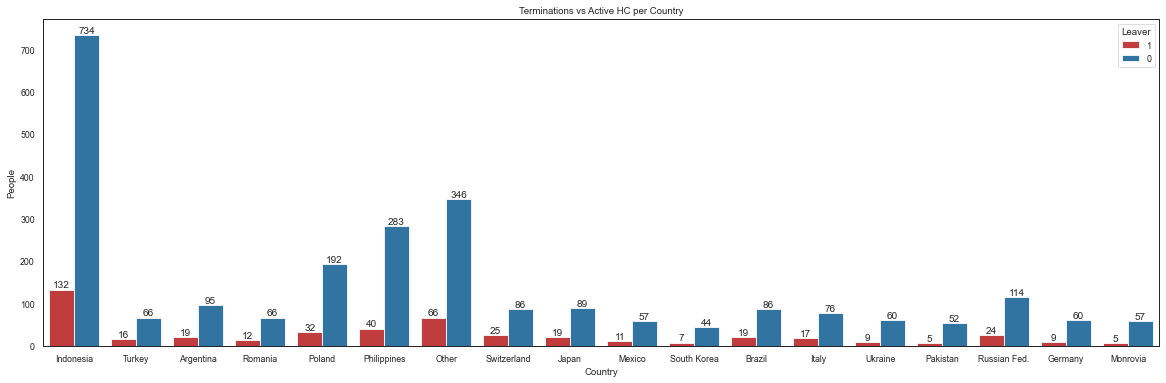

In [4]:
# % of Terminations from Total HC per Country
count_Country_total=df.Country.value_counts()
count_Country_terminated=df_terminated.Country.value_counts()
totalpercent_Country = (count_Country_terminated/count_Country_total)*100
Terminations_Country = round(totalpercent_Country.sort_values(ascending=False),1)
print("% of Terminations from Total HC per Country:""\n",Terminations_Country)

palette = {
    0: 'tab:blue',
    1: 'tab:red',
}
fig, ax = plt.subplots(figsize=(20, 6))
sns.countplot(data=df, x="Country", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Country')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(ylabel='People')
plt.show()

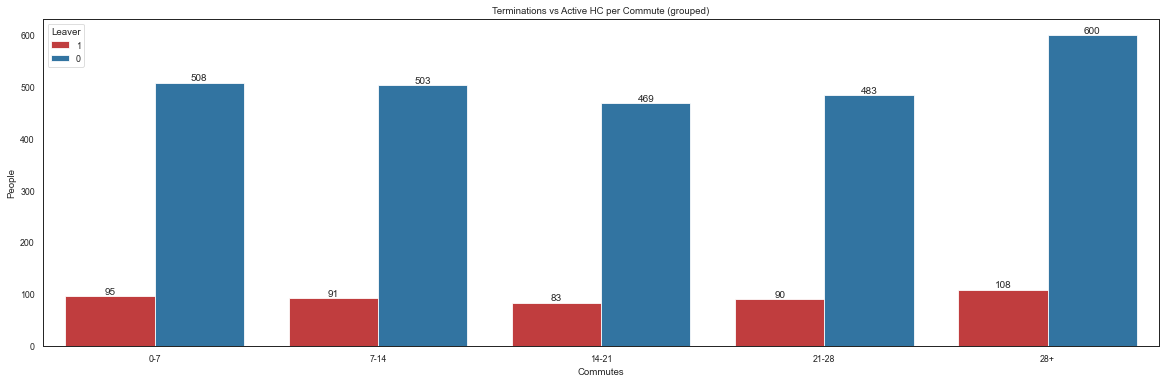

In [5]:
# Plot Terminations vs Total HC per Commute
fig, ax = plt.subplots(figsize=(20, 6))
sns.countplot(data=df, x="Commutes", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Commute (grouped)')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(ylabel='People')
plt.show()

<AxesSubplot: xlabel='Commute', ylabel='Actualmonthlypay'>

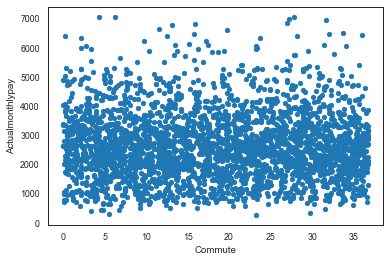

In [6]:
# Plot Commute vs Actual Monthly pay, no influence discovered between them 
df.plot(kind='scatter', x='Commute', y='Actualmonthlypay')

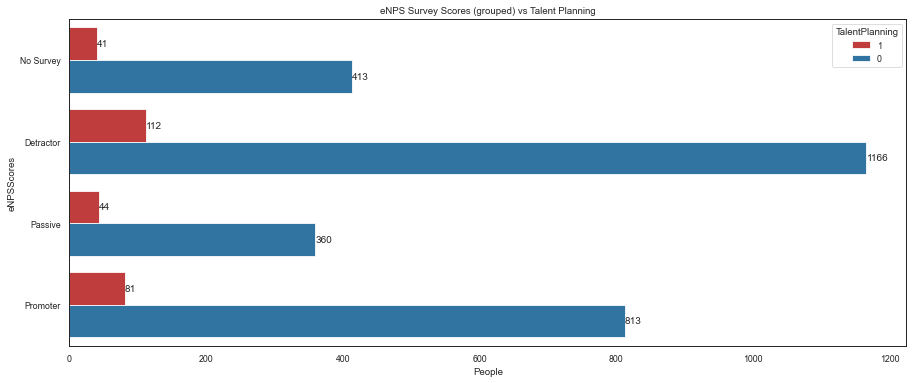

In [40]:
# Plot eNPS Survey Scores (grouped) vs Talent Planning
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(data=df, y="eNPSScores", hue="TalentPlanning",palette=palette,hue_order=[1,0]).set(title='eNPS Survey Scores (grouped) vs Talent Planning')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

% of Terminations from Total HC per Grades (grouped):
 11-15    16.1
6-10     15.5
1-5      14.8
16-20    14.2
20+      13.5
Name: Grades, dtype: float64


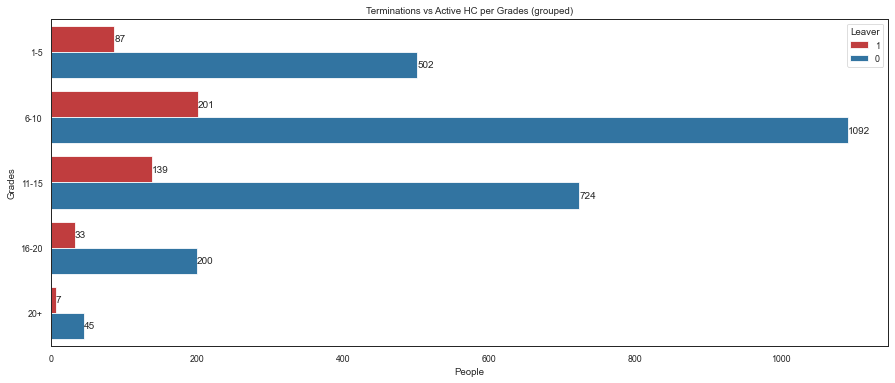

In [7]:
# % of Terminations from Total HC per Grades
count_Grades_total=df.Grades.value_counts()
count_Grades_terminated=df_terminated.Grades.value_counts()
totalpercent_Grades = (count_Grades_terminated/count_Grades_total)*100
print("% of Terminations from Total HC per Grades (grouped):""\n",round(totalpercent_Grades.sort_values(ascending=False),1))

# Grades analysis per Country (exported values as columns in Excel file)
# Grades1
grouping = df.groupby(['Country'])
def Grades1_Country(grouping):  
    (group_label, df) = grouping
    Grade1 = round((len(df[(df['Grades']=='1-5') & (df['Leaver']==1)])/len(df[df['Grades']=='1-5']))*100,1)
    return({group_label: Grade1})
ratios_grades1 = [Grades1_Country(i).values() for i in grouping]
Ratios_Grades1 = pd.DataFrame(data = ratios_grades1, index = grouping.groups, columns = ['Grade1'])

# Grades2
grouping = df.groupby(['Country'])
def Grades2_Country(grouping):  
    (group_label, df) = grouping
    Grade2 = round((len(df[(df['Grades']=='6-10') & (df['Leaver']==1)])/len(df[df['Grades']=='6-10']))*100,1)
    return({group_label: Grade2})
ratios_grades2 = [Grades2_Country(i).values() for i in grouping]
Ratios_Grades2 = pd.DataFrame(data = ratios_grades2, index = grouping.groups, columns = ['Grade2'])

# Grades3
grouping = df.groupby(['Country'])
def Grades3_Country(grouping):  
    (group_label, df) = grouping
    Grade3 = round((len(df[(df['Grades']=='11-15') & (df['Leaver']==1)])/len(df[df['Grades']=='11-15']))*100,1)
    return({group_label: Grade3})
ratios_grades3 = [Grades3_Country(i).values() for i in grouping]
Ratios_Grades3 = pd.DataFrame(data = ratios_grades3, index = grouping.groups, columns = ['Grade3'])

# Grades4
grouping = df.groupby(['Country'])
def Grades4_Country(grouping):  
    (group_label, df) = grouping
    Grade4 = round((len(df[(df['Grades']=='16-20') & (df['Leaver']==1)])/len(df[df['Grades']=='16-20']))*100,1)
    return({group_label: Grade4})
ratios_grades4 = [Grades4_Country(i).values() for i in grouping]
Ratios_Grades4 = pd.DataFrame(data = ratios_grades4, index = grouping.groups, columns = ['Grade4'])

# Grades5
grouping = df.groupby(['Country'])
def Grades5_Country(grouping):  
    (group_label, df) = grouping
    try:
        Grade5 = round((len(df[(df['Grades']=='20+') & (df['Leaver']==1)])/len(df[df['Grades']=='20+']))*100,1)
        return({group_label: Grade5})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_grades5 = [Grades5_Country(i).values() for i in grouping]
Ratios_Grades5 = pd.DataFrame(data = ratios_grades5, index = grouping.groups, columns = ['Grade5'])

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(data=df, y="Grades", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Grades (grouped)')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

% of Terminations from Total HC per Gender:
 0    20.4
1    13.1
Name: Gender, dtype: float64


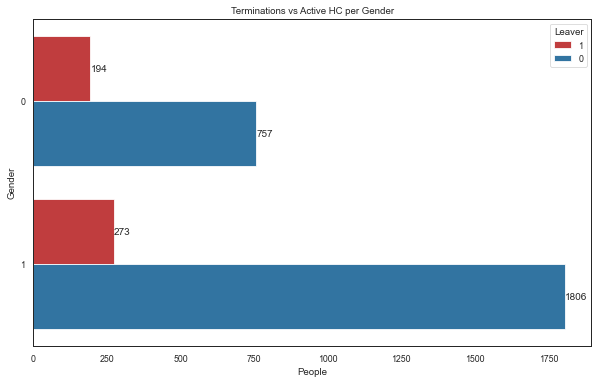

In [8]:
# % of Terminations from Total HC per Gender
count_Gender_total=df.Gender.value_counts()
count_Gender_terminated=df_terminated.Gender.value_counts()
totalpercent_TalentPlanning = (count_Gender_terminated/count_Gender_total)*100
print("% of Terminations from Total HC per Gender:""\n",round(totalpercent_TalentPlanning.sort_values(ascending=False),1))

# Grades analysis per Gender (exported values as columns in Excel file)
# Female
grouping = df.groupby(['Country'])
def Female_Country(grouping):  
    (group_label, df) = grouping
    Female = round((len(df[(df['Gender']==0) & (df['Leaver']==1)])/len(df[df['Gender']==0]))*100,1)
    return({group_label: Female})
ratios_Female = [Female_Country(i).values() for i in grouping]
Ratios_Female = pd.DataFrame(data = ratios_Female, index = grouping.groups, columns = ['Female'])

# Male
grouping = df.groupby(['Country'])
def Male_Country(grouping):  
    (group_label, df) = grouping
    Male = round((len(df[(df['Gender']==1) & (df['Leaver']==1)])/len(df[df['Gender']==1]))*100,1)
    return({group_label: Male})
ratios_Male = [Male_Country(i).values() for i in grouping]
Ratios_Male = pd.DataFrame(data = ratios_Male, index = grouping.groups, columns = ['Male'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, y="Gender", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Gender')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

% of Terminations from Total HC per Talent Planning:
 1    21.9
0    14.8
Name: TalentPlanning, dtype: float64


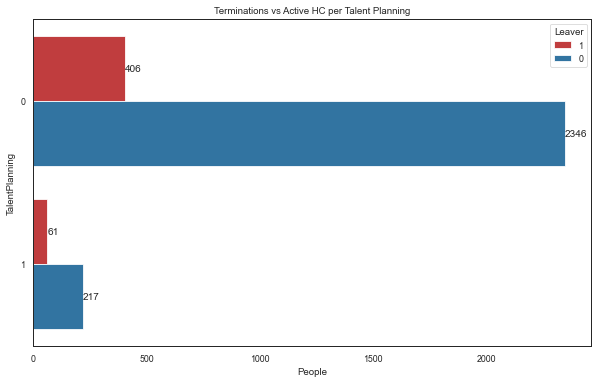

In [9]:
# % of Terminations from Total HC per Talent Planning
count_TalentPlanning_total=df.TalentPlanning.value_counts()
count_TalentPlanning_terminated=df_terminated.TalentPlanning.value_counts()
totalpercent_TalentPlanning = (count_TalentPlanning_terminated/count_TalentPlanning_total)*100
print("% of Terminations from Total HC per Talent Planning:""\n",round(totalpercent_TalentPlanning.sort_values(ascending=False),1))

# Talent Planning analysis per Country (exported values as columns in Excel file)
# Other:0
grouping = df.groupby(['Country'])
def TP0(grouping):  
    (group_label, df) = grouping
    Talent_Planning_0 = round((len(df[(df['TalentPlanning']==0) & (df['Leaver']==1)])/len(df[df['TalentPlanning']==0]))*100,1)
    return({group_label: Talent_Planning_0})
ratios_tp0 = [TP0(i).values() for i in grouping]
Ratios_TP0 = pd.DataFrame(data = ratios_tp0, index = grouping.groups, columns = ['Talent_Planning_0'])

# High Potentials:1
grouping = df.groupby(['Country'])
def TP1(grouping):  
    (group_label, df) = grouping
    Talent_Planning_1 = round((len(df[(df['TalentPlanning']==1) & (df['Leaver']==1)])/len(df[df['TalentPlanning']==1]))*100,1)
    return({group_label: Talent_Planning_1})
ratios_tp1 = [TP1(i).values() for i in grouping]
Ratios_TP1 = pd.DataFrame(data = ratios_tp1, index = grouping.groups, columns = ['Talent_Planning_1'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, y="TalentPlanning", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Talent Planning')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

% of Terminations from Total HC per Is manager:
 1    20.3
0    14.0
Name: Ismanager, dtype: float64


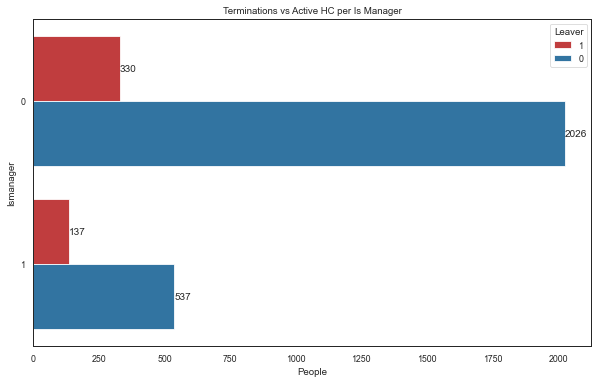

In [10]:
# % of Terminations from Total HC per Is manager
count_Ismanager_total=df.Ismanager.value_counts()
count_Ismanager_terminated=df_terminated.Ismanager.value_counts()
totalpercent_Ismanager = (count_Ismanager_terminated/count_Ismanager_total)*100
print("% of Terminations from Total HC per Is manager:""\n",round(totalpercent_Ismanager.sort_values(ascending=False),1))

# Is a Manager analysis per Country (exported values as columns in Excel file)
# No management responsability:0
grouping = df.groupby(['Country'])
def IsM0(grouping):  
    (group_label, df) = grouping
    IsM0 = round((len(df[(df['Ismanager']==0) & (df['Leaver']==1)])/len(df[df['Ismanager']==0]))*100,1)
    return({group_label: IsM0})
ratios_IsM0 = [IsM0(i).values() for i in grouping]
Ratios_IsM0 = pd.DataFrame(data = ratios_IsM0, index = grouping.groups, columns = ['IsM0'])

# Is a Manager:1
grouping = df.groupby(['Country'])
def IsM1(grouping):  
    (group_label, df) = grouping
    IsM1 = round((len(df[(df['Ismanager']==1) & (df['Leaver']==1)])/len(df[df['Ismanager']==1]))*100,1)
    return({group_label: IsM1})
ratios_IsM1 = [IsM1(i).values() for i in grouping]
Ratios_IsM1 = pd.DataFrame(data = ratios_IsM1, index = grouping.groups, columns = ['IsM1'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, y="Ismanager", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Is Manager')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

% of Terminations from Total HC per Tenures (grouped):
 0-3 years      20.6
3-6 years      16.5
10-20 years    14.1
20 years +     13.1
6-10 years     12.2
Name: Tenures, dtype: float64


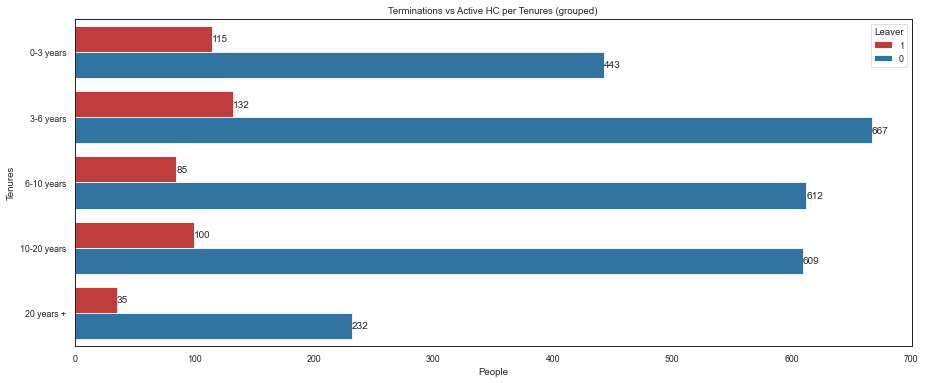

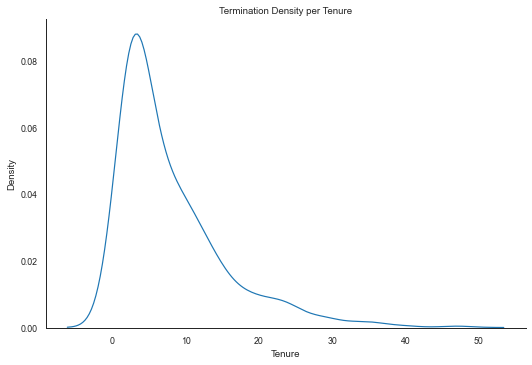

In [11]:
# % of Terminations from Total HC per Tenure (grouped)
count_Tenures_total=df.Tenures.value_counts()
count_Tenures_terminated=df_terminated.Tenures.value_counts()
totalpercent_Tenures = (count_Tenures_terminated/count_Tenures_total)*100
print("% of Terminations from Total HC per Tenures (grouped):""\n",round(totalpercent_Tenures.sort_values(ascending=False),1))

# Tenure analysis per Country (exported values as columns in Excel file)
# Tenures1
grouping = df.groupby(['Country'])
def Tenures1_Country(grouping):  
    (group_label, df) = grouping
    try:
        Tenure1 = round((len(df[(df['Tenures']=='0-3 years') & (df['Leaver']==1)])/len(df[df['Tenures']=='0-3 years']))*100,1)
        return({group_label: Tenure1})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_tenures1 = [Tenures1_Country(i).values() for i in grouping]
Ratios_Tenures1 = pd.DataFrame(data = ratios_tenures1, index = grouping.groups, columns = ['Tenure1'])

# Tenures2
grouping = df.groupby(['Country'])
def Tenures2_Country(grouping):  
    (group_label, df) = grouping
    Tenure2 = round((len(df[(df['Tenures']=='3-6 years') & (df['Leaver']==1)])/len(df[df['Tenures']=='3-6 years']))*100,1)
    return({group_label: Tenure2})
ratios_tenures2 = [Tenures2_Country(i).values() for i in grouping]
Ratios_Tenures2 = pd.DataFrame(data = ratios_tenures2, index = grouping.groups, columns = ['Tenure2'])

# Tenures3
grouping = df.groupby(['Country'])
def Tenures3_Country(grouping):  
    (group_label, df) = grouping
    Tenure3 = round((len(df[(df['Tenures']=='6-10 years') & (df['Leaver']==1)])/len(df[df['Tenures']=='6-10 years']))*100,1)
    return({group_label: Tenure3})
ratios_tenures3 = [Tenures3_Country(i).values() for i in grouping]
Ratios_Tenures3 = pd.DataFrame(data = ratios_tenures3, index = grouping.groups, columns = ['Tenure3'])

# Tenures4
grouping = df.groupby(['Country'])
def Tenures4_Country(grouping):  
    (group_label, df) = grouping
    Tenure4 = round((len(df[(df['Tenures']=='10-20 years') & (df['Leaver']==1)])/len(df[df['Tenures']=='10-20 years']))*100,1)
    return({group_label: Tenure4})
ratios_tenures4 = [Tenures4_Country(i).values() for i in grouping]
Ratios_Tenures4 = pd.DataFrame(data = ratios_tenures4, index = grouping.groups, columns = ['Tenure4'])

# Tenures5
grouping = df.groupby(['Country'])
def Tenures5_Country(grouping):  
    (group_label, df) = grouping
    Tenure5 = round((len(df[(df['Tenures']=='20 years +') & (df['Leaver']==1)])/len(df[df['Tenures']=='20 years +']))*100,1)
    return({group_label: Tenure5})
ratios_tenures5 = [Tenures5_Country(i).values() for i in grouping]
Ratios_Tenures5 = pd.DataFrame(data = ratios_tenures5, index = grouping.groups, columns = ['Tenure5'])

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(data=df, y="Tenures", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Tenures (grouped)')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
sns.displot(data=df_terminated, x="Tenure", kind="kde", aspect=1.5).set(title='Termination Density per Tenure')
plt.close(1)
plt.show()


% of Terminations from Total HC per Time in latest role (grouped):
 1-3 years     19.3
10 years +    15.7
0-1 years     15.4
3-6 years     14.7
6-10 years    12.9
Name: Timeinlatestroles, dtype: float64


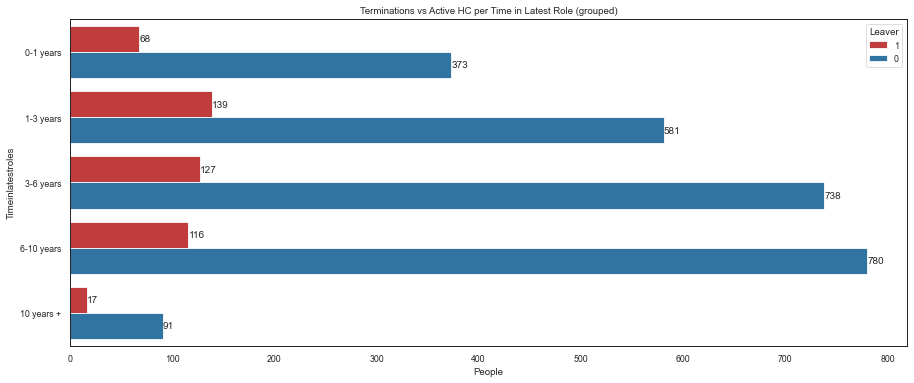

In [12]:
# % of Terminations from Total HC per Time in latest role (grouped)
count_Timeinlatestroles_total=df.Timeinlatestroles.value_counts()
count_Timeinlatestroles_terminated=df_terminated.Timeinlatestroles.value_counts()
totalpercent_Timeinlatestroles = (count_Timeinlatestroles_terminated/count_Timeinlatestroles_total)*100
print("% of Terminations from Total HC per Time in latest role (grouped):""\n",round(totalpercent_Timeinlatestroles.sort_values(ascending=False),1))

# Time in latest role analysis per Country (exported values as columns in Excel file)
# LatestRole1
grouping = df.groupby(['Country'])
def Latestrole1_Country(grouping):  
    (group_label, df) = grouping
    try:
        Latestrole1 = round((len(df[(df['Timeinlatestroles']=='0-1 years') & (df['Leaver']==1)])/len(df[df['Timeinlatestroles']=='0-1 years']))*100,1)
        return({group_label: Latestrole1})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_latestrole1 = [Latestrole1_Country(i).values() for i in grouping]
Ratios_Latestrole1 = pd.DataFrame(data = ratios_latestrole1, index = grouping.groups, columns = ['Latestrole1'])

# LatestRole2
grouping = df.groupby(['Country'])
def Latestrole2_Country(grouping):  
    (group_label, df) = grouping
    try:
        Latestrole2 = round((len(df[(df['Timeinlatestroles']=='1-3 years') & (df['Leaver']==1)])/len(df[df['Timeinlatestroles']=='1-3 years']))*100,1)
        return({group_label: Latestrole2})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_latestrole2 = [Latestrole2_Country(i).values() for i in grouping]
Ratios_Latestrole2 = pd.DataFrame(data = ratios_latestrole2, index = grouping.groups, columns = ['Latestrole2'])

# LatestRole3
grouping = df.groupby(['Country'])
def Latestrole3_Country(grouping):  
    (group_label, df) = grouping
    try:
        Latestrole3 = round((len(df[(df['Timeinlatestroles']=='3-6 years') & (df['Leaver']==1)])/len(df[df['Timeinlatestroles']=='3-6 years']))*100,1)
        return({group_label: Latestrole3})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_latestrole3 = [Latestrole3_Country(i).values() for i in grouping]
Ratios_Latestrole3 = pd.DataFrame(data = ratios_latestrole3, index = grouping.groups, columns = ['Latestrole3'])

# LatestRole4
grouping = df.groupby(['Country'])
def Latestrole4_Country(grouping):  
    (group_label, df) = grouping
    try:
        Latestrole4 = round((len(df[(df['Timeinlatestroles']=='6-10 years') & (df['Leaver']==1)])/len(df[df['Timeinlatestroles']=='6-10 years']))*100,1)
        return({group_label: Latestrole4})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_latestrole4 = [Latestrole4_Country(i).values() for i in grouping]
Ratios_Latestrole4 = pd.DataFrame(data = ratios_latestrole4, index = grouping.groups, columns = ['Latestrole4'])

# LatestRole5
grouping = df.groupby(['Country'])
def Latestrole5_Country(grouping):  
    (group_label, df) = grouping
    try:
        Latestrole5 = round((len(df[(df['Timeinlatestroles']=='10 years +') & (df['Leaver']==1)])/len(df[df['Timeinlatestroles']=='10 years +']))*100,1)
        return({group_label: Latestrole5})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_latestrole5 = [Latestrole5_Country(i).values() for i in grouping]
Ratios_Latestrole5 = pd.DataFrame(data = ratios_latestrole5, index = grouping.groups, columns = ['Latestrole5'])

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(data=df, y="Timeinlatestroles", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Time in Latest Role (grouped)')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

% of Terminations from Total HC per Function:
 Marketing               21.2
External Affairs        20.8
Science & Innovation    19.5
Other                   17.3
Sales                   15.7
Operations              14.6
Finance                 12.3
Information Services    12.0
Support Services        11.3
People & Culture        10.0
Name: Function, dtype: float64


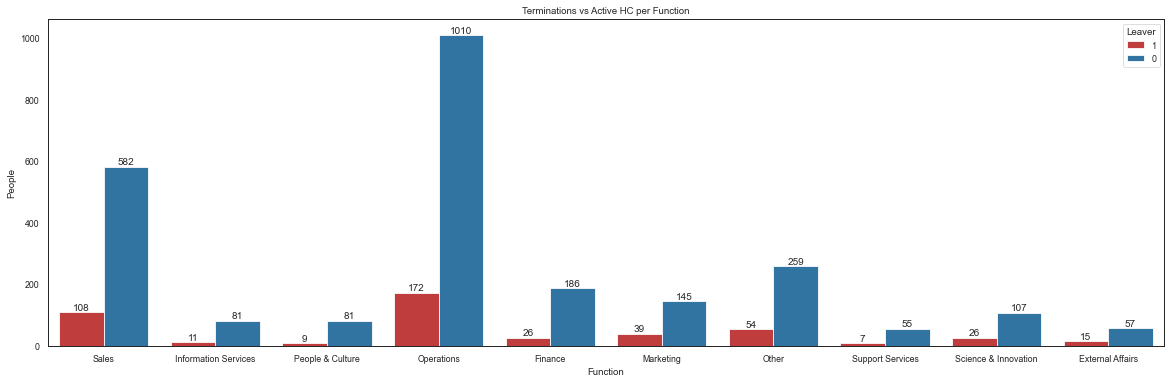

In [13]:
# % of Terminations from Total HC per Function
count_Function_total=df.Function.value_counts()
count_Function_terminated=df_terminated.Function.value_counts()
totalpercent = (count_Function_terminated/count_Function_total)*100
print("% of Terminations from Total HC per Function:""\n",round(totalpercent.sort_values(ascending=False),1))

# Functions analysis per Country (exported values as columns in Excel file)
# Marketing
grouping = df.groupby(['Country'])
def Marketing_Country(grouping):  
    (group_label, df) = grouping
    try:
        Marketing = round((len(df[(df['Function']=='Marketing') & (df['Leaver']==1)])/len(df[df['Function']=='Marketing']))*100,1)
        return({group_label: Marketing})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_Marketing = [Marketing_Country(i).values() for i in grouping]
Ratios_Marketing = pd.DataFrame(data = ratios_Marketing, index = grouping.groups, columns = ['Marketing'])

# External Affairs
grouping = df.groupby(['Country'])
def ExternalAffairs_Country(grouping):  
    (group_label, df) = grouping
    try:
        ExternalAffairs = round((len(df[(df['Function']=='External Affairs') & (df['Leaver']==1)])/len(df[df['Function']=='External Affairs']))*100,1)
        return({group_label: ExternalAffairs})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_ExternalAffairs = [ExternalAffairs_Country(i).values() for i in grouping]
Ratios_ExternalAffairs = pd.DataFrame(data = ratios_ExternalAffairs, index = grouping.groups, columns = ['ExternalAffairs'])

# External Affairs
grouping = df.groupby(['Country'])
def Science_Country(grouping):  
    (group_label, df) = grouping
    try:
        ScienceInnovation = round((len(df[(df['Function']=='Science & Innovation') & (df['Leaver']==1)])/len(df[df['Function']=='Science & Innovation']))*100,1)
        return({group_label: ScienceInnovation})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_Science = [Science_Country(i).values() for i in grouping]
Ratios_Science = pd.DataFrame(data = ratios_Science, index = grouping.groups, columns = ['ScienceInnovation'])

fig, ax = plt.subplots(figsize=(20, 6))
sns.countplot(data=df, x="Function", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Function')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(ylabel='People')
plt.show()

In [14]:
# % of Terminations from Total HC per Employee Group
count_EmployeeGroup_total=df.EmployeeGroup.value_counts()
count_EmployeeGroup_terminated=df_terminated.EmployeeGroup.value_counts()
totalpercent = (count_EmployeeGroup_terminated/count_EmployeeGroup_total)*100
print("% of Terminations from Total HC per Employee Group:""\n",round(totalpercent.sort_values(ascending=False),1))

% of Terminations from Total HC per Employee Group:
 Temporary    16.4
Standard     15.3
Other        12.7
Name: EmployeeGroup, dtype: float64


% of Terminations from Total HC per per eNPS Survey Score:
 No Survey    29.7
Passive      14.1
Detractor    13.7
Promoter     11.2
Name: eNPSScores, dtype: float64


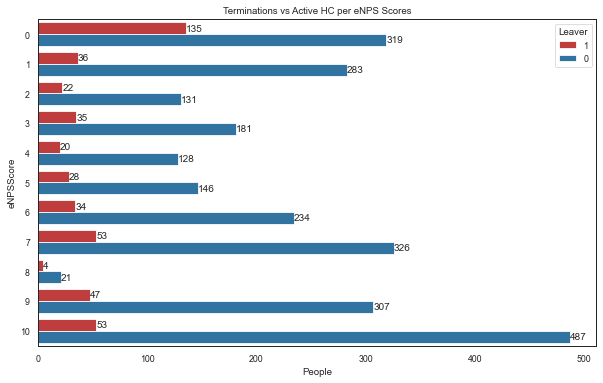

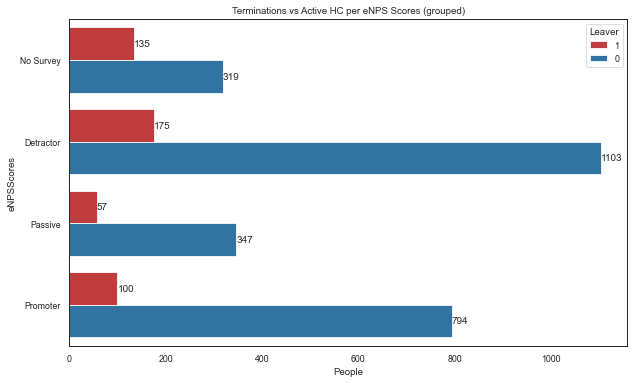

In [15]:
# % of Terminations from Total HC per eNPS Survey Score
count_eNPSScores_total=df.eNPSScores.value_counts()
count_eNPSScores_terminated=df_terminated.eNPSScores.value_counts()
totalpercent = (count_eNPSScores_terminated/count_eNPSScores_total)*100
print("% of Terminations from Total HC per per eNPS Survey Score:""\n",round(totalpercent.sort_values(ascending=False),1))

# eNPS analysis per Country (exported values as columns in Excel file)
# eNPSNoSurvey
grouping = df.groupby(['Country'])
def eNPSNoSurvey_Country(grouping):  
    (group_label, df) = grouping
    try:
        eNPSNoSurvey = round((len(df[(df['eNPSScores']=='No Survey') & (df['Leaver']==1)])/len(df[df['eNPSScores']=='No Survey']))*100,1)
        return({group_label: eNPSNoSurvey})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_eNPSNoSurvey = [eNPSNoSurvey_Country(i).values() for i in grouping]
Ratios_eNPSNoSurvey = pd.DataFrame(data = ratios_eNPSNoSurvey, index = grouping.groups, columns = ['eNPSNoSurvey'])

# eNPSDetractor
grouping = df.groupby(['Country'])
def eNPSDetractor_Country(grouping):  
    (group_label, df) = grouping
    try:
        eNPSDetractor = round((len(df[(df['eNPSScores']=='Detractor') & (df['Leaver']==1)])/len(df[df['eNPSScores']=='Detractor']))*100,1)
        return({group_label: eNPSDetractor})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_eNPSDetractor = [eNPSDetractor_Country(i).values() for i in grouping]
Ratios_eNPSDetractor = pd.DataFrame(data = ratios_eNPSDetractor, index = grouping.groups, columns = ['eNPSDetractor'])

# eNPSPassive
grouping = df.groupby(['Country'])
def eNPSPassive_Country(grouping):  
    (group_label, df) = grouping
    try:
        eNPSPassive = round((len(df[(df['eNPSScores']=='Passive') & (df['Leaver']==1)])/len(df[df['eNPSScores']=='Passive']))*100,1)
        return({group_label: eNPSPassive})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_eNPSPassive = [eNPSPassive_Country(i).values() for i in grouping]
Ratios_eNPSPassive = pd.DataFrame(data = ratios_eNPSPassive, index = grouping.groups, columns = ['eNPSPassive'])

# eNPSPromoter
grouping = df.groupby(['Country'])
def eNPSPromoter_Country(grouping):  
    (group_label, df) = grouping
    try:
        eNPSPromoter = round((len(df[(df['eNPSScores']=='Promoter') & (df['Leaver']==1)])/len(df[df['eNPSScores']=='Promoter']))*100,1)
        return({group_label: eNPSPromoter})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_eNPSPromoter = [eNPSPromoter_Country(i).values() for i in grouping]
Ratios_eNPSPromoter = pd.DataFrame(data = ratios_eNPSPromoter, index = grouping.groups, columns = ['eNPSPromoter'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, y="eNPSScore", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per eNPS Scores')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, y="eNPSScores", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per eNPS Scores (grouped)')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

% of Terminations from Total HC per Well-Being Survey Score:
 0    29.7
1    23.2
3    13.7
5    11.7
2    10.3
4    10.1
Name: WellBeing, dtype: float64


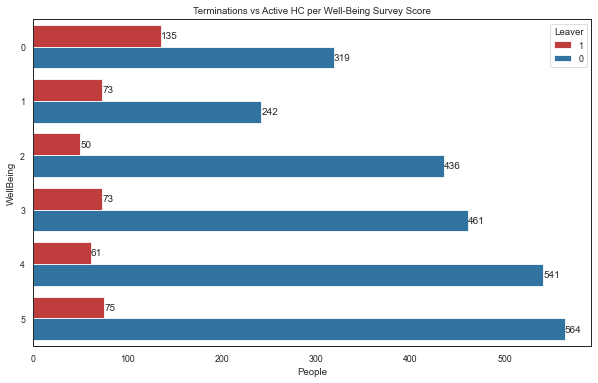

In [16]:
# % of Terminations from Total HC per Well-Being Survey Score
count_WellBeing_total=df.WellBeing.value_counts()
count_WellBeing_terminated=df_terminated.WellBeing.value_counts()
totalpercent = (count_WellBeing_terminated/count_WellBeing_total)*100
print("% of Terminations from Total HC per Well-Being Survey Score:""\n",round(totalpercent.sort_values(ascending=False),1))

# Well-Being analysis per Country (exported values as columns in Excel file)
# WellBeing1
grouping = df.groupby(['Country'])
def WellBeing1_Country(grouping):  
    (group_label, df) = grouping
    try:
        WellBeing1 = round((len(df[(df['WellBeing']==1) & (df['Leaver']==1)])/len(df[df['WellBeing']==1]))*100,1)
        return({group_label: WellBeing1})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_WellBeing1 = [WellBeing1_Country(i).values() for i in grouping]
Ratios_WellBeing1 = pd.DataFrame(data = ratios_WellBeing1, index = grouping.groups, columns = ['WellBeing1'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, y="WellBeing", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Well-Being Survey Score')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()


% of Terminations from Total HC per Career Opportunities Survey Score:
 0    29.7
5    14.1
4    14.1
1    13.2
3    11.6
2    11.2
Name: CareerOps, dtype: float64


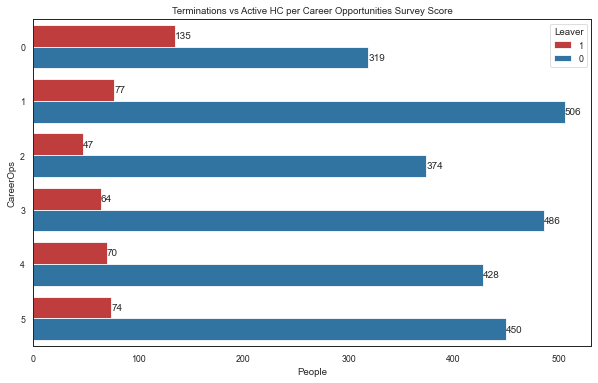

In [17]:
# % of Terminations from Total HC per Career Opportunities Survey Score
count_CareerOps_total=df.CareerOps.value_counts()
count_CareerOps_terminated=df_terminated.CareerOps.value_counts()
totalpercent = (count_CareerOps_terminated/count_CareerOps_total)*100
print("% of Terminations from Total HC per Career Opportunities Survey Score:""\n",round(totalpercent.sort_values(ascending=False),1))

# Career Opportunities analysis per Country
# CareerOps1
grouping = df.groupby(['Country'])
def CareerOps1_Country(grouping):  
    (group_label, df) = grouping
    try:
        CareerOps1 = round((len(df[(df['CareerOps']==1) & (df['Leaver']==1)])/len(df[df['CareerOps']==1]))*100,1)
        return({group_label: CareerOps1})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_CareerOps1 = [CareerOps1_Country(i).values() for i in grouping]
Ratios_CareerOps1 = pd.DataFrame(data = ratios_CareerOps1, index = grouping.groups, columns = ['CareerOps1'])

# CareerOps5
grouping = df.groupby(['Country'])
def CareerOps5_Country(grouping):  
    (group_label, df) = grouping
    try:
        CareerOps5 = round((len(df[(df['CareerOps']==5) & (df['Leaver']==1)])/len(df[df['CareerOps']==5]))*100,1)
        return({group_label: CareerOps5})
    except ZeroDivisionError:
        return({group_label: 0})
ratios_CareerOps5 = [CareerOps5_Country(i).values() for i in grouping]
Ratios_CareerOps5 = pd.DataFrame(data = ratios_CareerOps5, index = grouping.groups, columns = ['CareerOps5'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, y="CareerOps", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Career Opportunities Survey Score')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

% of Terminations from Total HC per Recognition Survey Score:
 0    29.7
4    15.5
1    13.2
2    12.2
3    11.9
5    11.6
Name: Recognition, dtype: float64


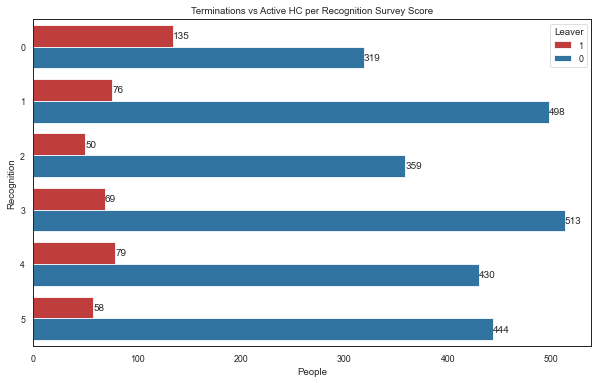

In [18]:
# % of Terminations from Total HC per Recognition Survey Score
count_Recognition_total=df.Recognition.value_counts()
count_Recognition_terminated=df_terminated.Recognition.value_counts()
totalpercent = (count_Recognition_terminated/count_Recognition_total)*100
print("% of Terminations from Total HC per Recognition Survey Score:""\n",round(totalpercent.sort_values(ascending=False),1))

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, y="Recognition", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Recognition Survey Score')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

% of Terminations from Total HC per Line manager rating survey score:
 0    29.7
2    14.7
4    14.5
5    13.4
3    11.6
1    11.1
Name: LineManager, dtype: float64


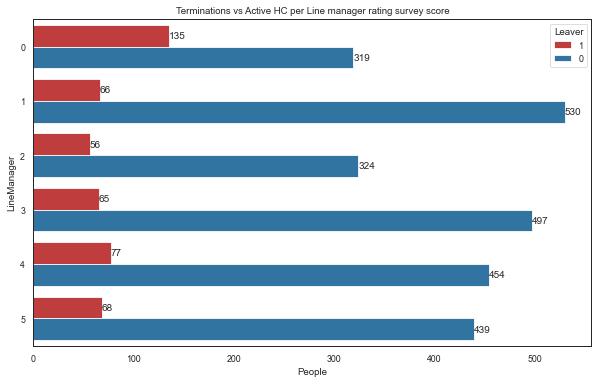

In [19]:
# % of Terminations from Total HC per Line manager rating survey score
count_LineManager_total=df.LineManager.value_counts()
count_LineManager_terminated=df_terminated.LineManager.value_counts()
totalpercent = (count_LineManager_terminated/count_LineManager_total)*100
print("% of Terminations from Total HC per Line manager rating survey score:""\n",round(totalpercent.sort_values(ascending=False),1))

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, y="LineManager", hue="Leaver",palette=palette,hue_order=[1,0]).set(title='Terminations vs Active HC per Line manager rating survey score')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
ax.set(xlabel='People')
plt.show()

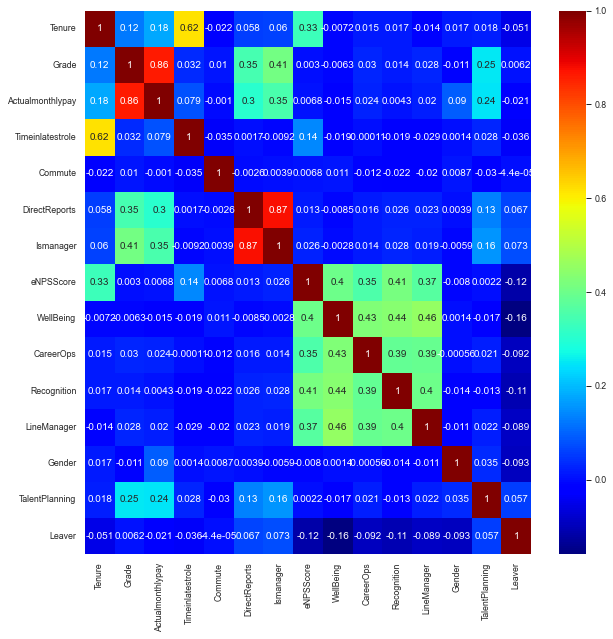

In [20]:
# Plot a Heatmap to analyze Correlations between variables
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(),annot=True,cmap='jet')
plt.show()


In [21]:
# Turnover by Country (exported values as columns in Excel file)
grouping = df.groupby(['Country'])
def Turnover_Country(grouping):  
    (group_label, df) = grouping
    Turnover = round(len(df[df.Leaver == 1])/((len(df[df.Tenure >=1])+len(df[df.Leaver == 0]))/2)*100,1)
    return({group_label: Turnover})
ratios_turnover = [Turnover_Country(i).values() for i in grouping]

In [22]:
# Create dataframe with analyzed values per Country
Countries = pd.DataFrame(data = ratios_turnover, index = grouping.groups, columns = ['Turnover']).sort_values(by=['Turnover'], ascending=False)
Countries['Terminated HC'] = count_Country_terminated
Countries['Total HC'] = count_Country_total
Countries['% Terminations'] = Terminations_Country
Countries['% T Grades1'] = Ratios_Grades1
Countries['% T Grades2'] = Ratios_Grades2
Countries['% T Grades3'] = Ratios_Grades3
Countries['% T Grades4'] = Ratios_Grades4
Countries['% T Grades5'] = Ratios_Grades5
Countries['% T Talent Planning 0'] = Ratios_TP0
Countries['% T Talent Planning 1'] = Ratios_TP1
Countries['% T Is a Manager 0'] = Ratios_IsM0
Countries['% T Is a Manager 1'] = Ratios_IsM1
Countries['% T Tenures1'] = Ratios_Tenures1
Countries['% T Tenures2'] = Ratios_Tenures2
Countries['% T Tenures3'] = Ratios_Tenures3
Countries['% T Tenures4'] = Ratios_Tenures4
Countries['% T Tenures5'] = Ratios_Tenures5
Countries['% T Latest role1'] = Ratios_Latestrole1
Countries['% T Latest role2'] = Ratios_Latestrole2
Countries['% T Latest role3'] = Ratios_Latestrole3
Countries['% T Latest role4'] = Ratios_Latestrole4
Countries['% T Latest role5'] = Ratios_Latestrole5
Countries['% T Marketing'] = Ratios_Marketing
Countries['% T External Affairs'] = Ratios_ExternalAffairs
Countries['% T Science & Innovation'] = Ratios_Science
Countries['% T No Survey'] = Ratios_eNPSNoSurvey
Countries['% T Detractor'] = Ratios_eNPSDetractor
Countries['% T Passive'] = Ratios_eNPSPassive
Countries['% T Promoter'] = Ratios_eNPSPromoter
Countries['% T Well-Being1'] = Ratios_WellBeing1
Countries['% T Female'] = Ratios_Female
Countries['% T Male'] = Ratios_Male

datadef = {'Dimension': ['Terminated HC','Total HC','% Terminations','% T Grades1','% T Grades2','% T Grades3','% T Grades4','% T Grades5','% T Talent Planning 0',
                         '% T Talent Planning 1','% T Is a Manager 0','% T Is a Manager 1','% T Tenures1','% T Tenures2','% T Tenures3','% T Tenures4','% T Tenures5',
                         '% T Latest role1','% T Latest role2','% T Latest role3','% T Latest role4','% T Latest role5','% T Marketing','% T External Affairs',
                         '% T Science & Innovation','% T Surveys No Survey','% T Detractor','% T Passive','% T Promoter','% T Well-Being1','% T Female','% T Male','Tenures1',
                         'Tenures2', 'Tenures3', 'Tenures4', 'Tenures5', 'Time in latest role1', 'Time in latest role2', 'Time in latest role3','Time in latest role4',
                         'Time in latest role5','Grades1', 'Grades2', 'Grades3', 'Grades4','Grades5','Detractor','Passive','Promoter'],
        'Group': ['-', '-', '-', 'Grade', 'Grade', 'Grade','Grade','Grade','Talent Planning','Talent Planning','Is a Manager','Is a Manager','Tenure','Tenure','Tenure',
                  'Tenure', 'Tenure','Time in latest role','Time in latest role','Time in latest role','Time in latest role','Time in latest role','Function','Function',
                  'Function','Surveys','Surveys','Surveys','Surveys','Surveys','Gender','Gender','0-3 years', '3-6 years', '6-10 years', '10-20 years', '20 years +',
                  '0-1 years', '1-3 years', '3-6 years', '6-10 years', '10 years +','1-5','6-10', '11-15','16-20', '20+','1-6','7-8','9-10'],
        'Scale/Definition': ['# of people who left the company in the period','total # of people in the period (including terminations)','From total HC, % Terminated',
                             'From total HC for Grades 1-5, % Terminated','From total HC for Grades 6-10, % Terminated','From total HC for Grades 11-15, % Terminated',
                             'From total HC for Grades 16-20, % Terminated', 'From total HC for Grades upper 20, % Terminated',
                             'From total HC for for Talent Planning: Other, % Terminated','From total HC for for Talent Planning: High Potential, % Terminated',
                             'From total HC for Not Managers, % Terminated','From total HC for Managers, % Terminated','From total HC for Tenure 0-3 years, % Terminated',
                             'From total HC for Tenure 3-6 years, % Terminated','From total HC for Tenure 6-10 years, % Terminated',
                             'From total HC for Tenure 10-20 years, % Terminated','From total HC for Tenure 20 years +, % Terminated',
                             'From total HC for Time in latest role 0-1 years, % Terminated','From total HC for Time in latest role 1-3 years, % Terminated',
                             'From total HC for Time in latest role 3-6 years, % Terminated','From total HC for Time in latest role 6-10 years, % Terminated',
                             'From total HC for Time in latest role 10 years +, % Terminated','From total HC for for Marketing functions, % Terminated',
                             'From total HC for for External Affairs functions, % Terminated','From total HC for for Science & Innovation functions, % Terminated',
                             'From total HC who ranked the eNPS Score as a Detractor, % Terminated', 'From total HC who ranked the eNPS Score as a Passive, % Terminated',
                             'From total HC who ranked the eNPS Score as a Promoter, % Terminated',
                             'From total HC for for for people who did not fill the employee surveys, % Terminated',
                             'From total HC who ranked Well-Being with Scale 1, % Terminated','From female total HC, % Terminated','From male total HC, % Terminated',
                             '<= 3 years', '> 3 & <= 6 years', '> 6 & <= 10 years', '> 10 & <= 20 years', '> 20 years', '<= 1 year', '> 1 & <= 3 years', '> 3 & <= 6 years',
                             '> 6 & <= 10 years', '> 10 years', '> 0 & <= 5 grade', '> 5 & <= 10 grade', '> 10 & <= 15 grade', '> 15 & <= 20 grade', '> 20 grade',
                             '1-6 Survey Scale','7-8 Survey Scale','9-10 Survey Scale']}

Datadefinitions = pd.DataFrame(data = datadef, columns = ['Dimension', 'Group', 'Scale/Definition'])

Switzerland     25.6
Turkey          22.2
Italy           20.4
Brazil          20.1
Japan           19.5
Russian Fed.    19.1
Argentina       18.7
Mexico          17.6
Other           17.6
Romania         16.9
Indonesia       16.8
Poland          15.6
South Korea     14.9
Ukraine         14.2
Germany         14.2
Philippines     13.2
Pakistan         9.2
Monrovia         8.4
Name: Turnover, dtype: float64


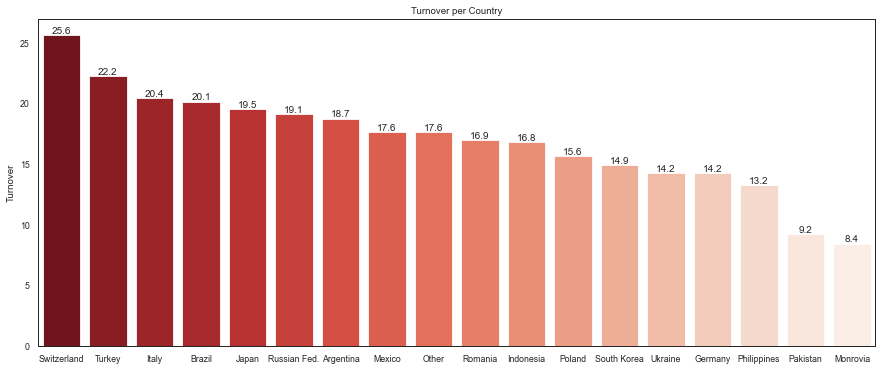

In [23]:
# Plot Turnover per Country
print(Countries['Turnover'])
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x = Countries.index,
              y = 'Turnover',
              data = Countries,
              ax = ax,
              palette="Reds_r",
              estimator = np.sum,
              ci = None).set(title='Turnover per Country')
for container in ax.containers:
    ax.bar_label(container)
sns.color_palette("Paired")
plt.show()

In [24]:
# Predictive analysis
df_analysis = df
df_analysis = df_analysis.drop(['Actualmonthlypay','DirectReports','Tenures','Timeinlatestroles','Grades','Commutes','eNPSScores'], axis=1)
df_analysis.columns

# Encode category variables into numerical
variablesfalt=df_analysis.select_dtypes("object").columns
LE=LabelEncoder()
for col in variablesfalt:
  df_analysis[col]=LE.fit_transform(df_analysis[col])

# Define X, y for the analysis  
X = df_analysis.drop('Leaver', 1)
y = df_analysis['Leaver'] 

# Feature selection to only keep useful variables for the Model
def forward_selection(data, target, significance_level=0.01):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features
forward_selection(X,y)

['WellBeing', 'Gender', 'Ismanager', 'eNPSScore', 'TalentPlanning']

In [25]:
# Make a first attempt with Modelling
X = df_analysis[['WellBeing', 'Gender', 'Ismanager', 'eNPSScore', 'TalentPlanning']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


In [26]:
# Although the model has a great accuracy, we know that the df is unbalanced (few Leavers in relation with Employees). We use SMOTE to balanced it
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.3, random_state = 42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.64


<Figure size 720x432 with 0 Axes>

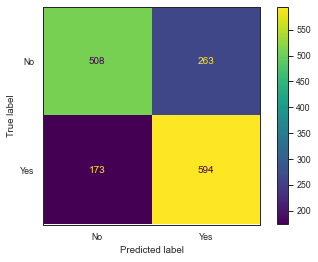

In [27]:
# Second attempt with Modelling, now with the df balanced
rf=RandomForestClassifier(random_state=1)
rf.fit(X_train,y_train)
results_rf=rf.predict(X_test)
confusion_matrix(y_test,results_rf)
plt.figure(figsize=(10,6)) #Plot the confusion matrix
plot_confusion_matrix(rf, X_test, y_test, display_labels=['No', 'Yes'])

In [28]:
# Compare Models performances in order to only keep the best one
tree= DecisionTreeClassifier(random_state=42)
knn= KNeighborsClassifier()
svm= SVC(random_state=42)
xboost= XGBClassifier(random_state=42)

# Create a list with Models
models= [tree, rf, knn, svm, xboost]

#Train each of the Models
# Compare Accuracy
for model in models: 
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    accuracy= accuracy_score(y_test, y_pred) # Obtain the Accuracy metrics
    clf_report= classification_report(y_test, y_pred) # Make a report with metrics for each Model
    print(f"The accuracy for the model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")

# Compare training time
for model in models:
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    lapse = end-start
    print(f"The training time for the model {type(model).__name__} is {lapse:.2f} s")

# Compare inference time
for model in models:
    model.fit(X_train, y_train)
    start = time.time()
    y_pred= model.predict(X_test)
    end = time.time()
    lapse = end-start
    print(f"The inference time for the model {type(model).__name__} is {lapse:.2f} s")

The accuracy for the model DecisionTreeClassifier is 0.71
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       771
           1       0.69      0.76      0.72       767

    accuracy                           0.71      1538
   macro avg       0.71      0.71      0.71      1538
weighted avg       0.71      0.71      0.71      1538



The accuracy for the model RandomForestClassifier is 0.72
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       771
           1       0.69      0.77      0.73       767

    accuracy                           0.72      1538
   macro avg       0.72      0.72      0.72      1538
weighted avg       0.72      0.72      0.72      1538



The accuracy for the model KNeighborsClassifier is 0.68
              precision    recall  f1-score   support

           0       0.69      0.64      0.67       771
           1       0.66      0.71      0.69       767

    ac

In [29]:
# As the chosen model is the RandomForestClassifier, extend the predictions for all the df
predict_df = model.predict(X)
df['Prediction'] = predict_df

with pd.ExcelWriter(r'C:\Users\ramir\Documents\PMI_Terminations_analysis.xlsx') as writer:
    Countries.to_excel(writer, sheet_name='Countries Overview', index=True)
    Datadefinitions.to_excel(writer, sheet_name='Countries data definitions', index=False)
    df.to_excel(writer, sheet_name='Data with prediction', index=True)